In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Configure Matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

class SolutionProperties:
    def __init__(self, wf_type, polyOrder, ndof_domain, star_option, dg_eps, etaI, etaB, k_sum, m_sum, b_hasNonZeroDampingMatrix, lumpMass, leftBC, rightBC, n_omega, omega, omega_pi, eigen_v, eig_r, eig_i, count):
        self.wf_type = wf_type
        self.polyOrder = polyOrder
        self.ndof_domain = ndof_domain
        self.star_option = star_option
        self.dg_eps = dg_eps
        self.etaI = etaI
        self.etaB = etaB
        self.k_sum = k_sum
        self.m_sum = m_sum
        self.b_hasNonZeroDampingMatrix = b_hasNonZeroDampingMatrix
        self.lumpMass = lumpMass
        self.leftBC = leftBC
        self.rightBC = rightBC
        self.n_omega = n_omega
        self.omega = omega
        self.omega_pi = omega_pi
        self.eigen_v = eigen_v 
        self.eig_r = eig_r  # 
        self.eig_i = eig_i  # 
        self.count = count

    def display_properties(self):
        print("wf_type:", self.wf_type)
        print("polyOrder:", self.polyOrder)
        print("ndof_domain:", self.ndof_domain)
        print("star_option:", self.star_option)
        print("dg_eps:", self.dg_eps)
        print("etaI:", self.etaI)
        print("etaB:", self.etaB)
        print("K.sum:", self.k_sum)
        print("M.sum:", self.m_sum)
        print("b_hasNonZeroDampingMatrix:", self.b_hasNonZeroDampingMatrix)
        print("lumpMass:", self.lumpMass)
        print("eigenvalues:", self.eigen_v)
        print("real parts of eigenvalues:", self.eig_r)
        print("imaginary parts of eigenvalues:", self.eig_i)

def read_keys(file_path):
# Open the text document and read its contents
    with open(file_path + '_0.txt', 'r') as file:
        contents = file.read()
    # Split the text into individual lines
    lines = contents.splitlines()
    lumpMass = False
    leftBC = 'Dirichlet'
    rightBC = 'Dirichlet'
    # Process each line
    for line in lines:
        # Split the line into key and value if a tab character is present
        if '\t' in line:
            key, value = line.split('\t')
            value = value.strip()
            # Assign the value to the corresponding variable based on the key
            if key == 'wf_type':
                wf_type = value
            elif key == 'polyOrder':
                polyOrder = int(value)
            elif key == 'ndof_domain':
                ndof_domain = int(value)
            elif key == 'star option':
                star_option = value
            elif key == 'dg_eps':
                dg_eps = int(value)
            elif key == 'etaI':
                etaI = float(value)
            elif key == 'etaB':
                etaB = float(value)
            elif key == 'K.sum':
                k_sum = value
            elif key == 'M.sum':
                m_sum = value
            elif key == 'b_hasNonZeroDampingMatrix':
                b_hasNonZeroDampingMatrix = int(value) 
            elif key == 'lumpMass':
                lumpMass = bool(value)
            elif key == 'leftBC':
                leftBC = value
            elif key == 'rightBC':
                rightBC = value

    data = []
    with open(file_path + '_eigen_0.txt', 'r') as file:
        for line in file:
            # Remove leading and trailing whitespaces
            line = line.strip()
            # Skip empty lines
            if line:
                # Extract the real and imaginary parts from the line
                real, imag = line.strip('()').split(',')
                # Convert the values to complex and append to the list
                data.append(complex(float(real), float(imag)))
    
    # Convert the list to a NumPy array
    eigenvalues = np.array(data)
    eig_r = eigenvalues.real
    eig_i = eigenvalues.imag

    n_omega = np.size(eigenvalues)
    #omega = np.zeros(n_omega)
    #omega_pi = np.zeros(n_omega)

    if leftBC == 'PeriodicOrBloch':
        print('PeriodicOrBloch')
        n_omega = n_omega-1

    if wf_type == 'cfem':
        omega = np.zeros(n_omega)
        omega_pi = np.zeros(n_omega)
        count = n_omega
        if leftBC == 'PeriodicOrBloch':
            eig_r = eig_r[1:]
            for i in range(n_omega):
                omega[i] = np.sqrt(eig_r[i])
                omega_pi[i] = np.sqrt(eig_r[i])/(i+2)/np.pi
        else:
            for i in range(n_omega):
                omega[i] = np.sqrt(eig_r[i])
                omega_pi[i] = np.sqrt(eig_r[i])/(i+1)/np.pi

    if wf_type == 'DG_1F_uStar':
        omega = np.zeros(n_omega)
        omega_pi = np.zeros(n_omega)
        count = n_omega
        if leftBC == 'PeriodicOrBloch':
            eig_r = eig_r[1:]
            for i in range(n_omega):
                omega[i] = np.sqrt(eig_r[i])
                omega_pi[i] = np.sqrt(eig_r[i])/(i+2)/np.pi
        else:
            for i in range(n_omega):
                omega[i] = np.sqrt(eig_r[i])
                omega_pi[i] = np.sqrt(eig_r[i])/(i+1)/np.pi

    if wf_type == 'DG_1F_vStar' or wf_type == 'DG_2FUV':
        mask = eig_i < -0.1
        count = np.sum(mask)
        if leftBC == 'PeriodicOrBloch':
            eig_i_negative = np.zeros(count)
            count = count-1
            omega = np.zeros(count)
            omega_pi = np.zeros(count)
            m = 0
            for i in range(n_omega):
                if eig_i[i] < -0.1:
                    eig_i_negative[m] = eig_i[i]
                    m = m + 1
            for i in range(count):
                omega[i] = (-eig_i_negative[i+1])
                omega_pi[i] = (-eig_i_negative[i+1])/(i+2)/np.pi
        else:
            omega = np.zeros(count)
            omega_pi = np.zeros(count)
            m = 0
            for i in range(n_omega):
                if eig_i[i] < -0.1:
                    omega[m] = (-eig_i[i])
                    omega_pi[m] = (-eig_i[i])/(m+1)/np.pi
                    m = m + 1

    #if wf_type == 'DG_2FUV':
    #    mask = eig_i < -0.1
    #    count = np.sum(mask)
    #    print(count)
    #    omega = np.zeros(count)
    #    omega_pi = np.zeros(count)
    #    m = 0
    #    for i in range(n_omega):
    #        if eig_i[i] < -0.1:
    #            omega[m] = np.sqrt(-eig_i[i])
    #            omega_pi[m] = np.sqrt(-eig_i[i])/(i+1)/np.pi
    #            m = m + 1

    solution = SolutionProperties(wf_type, polyOrder, ndof_domain, star_option, dg_eps, etaI, etaB, k_sum, m_sum, b_hasNonZeroDampingMatrix, lumpMass, leftBC, rightBC, n_omega, omega, omega_pi, eigenvalues, eig_r, eig_i, count)
    return solution

#def get_legend_label(solution):
#    wf_type = solution.wf_type
#    if wf_type == "DG_2FUV":
#        return "2F"
#    elif wf_type == "DG_1F_uStar":
#        return "u*"
#    elif wf_type == "DG_1F_vStar":
#        return "v*"
#    else:
#        return wf_type  # Use the original wf_type if it doesn't match the specified cases

def get_legend_label(solution):
    wf_type = solution.wf_type
    if wf_type == "DG_2FUV":
        wf_str = "2F"
    elif wf_type == "DG_1F_uStar":
        wf_str = "u*"
    elif wf_type == "DG_1F_vStar":
        wf_str = "v*"
    elif wf_type == "cfem":
        wf_str = "CFEM"
        if solution.lumpMass:
            return f'{wf_type}: p={solution.polyOrder}, lumped mass'
        else:
            return f'{wf_type}: p={solution.polyOrder}, consistent mass' 
    
    if solution.star_option == "Riemann":
        return f'{wf_str}, p={solution.polyOrder}, {solution.star_option}, $\\varepsilon$={solution.dg_eps}'
    else:
        return f'{wf_str}, p={solution.polyOrder}, {solution.star_option}, $\\varepsilon$={solution.dg_eps}, $\\eta_I$={solution.etaI}'


def plot_solutions(solutions):
    # Extract values for the x-axis (linspace) and y-axis (omega_pi)
    linspace_values = [np.linspace(0, 1, solution.count) for solution in solutions]
    omega_pi_values = [solution.omega_pi for solution in solutions]

    # Create a plot for each solution
    plt.figure(figsize=(6, 4))
    for i, solution in enumerate(solutions):
        #legend_label = f'{get_legend_label(solution)}, p={solution.polyOrder}, {solution.star_option}, $\\varepsilon$={solution.dg_eps}, $\\eta_I$={solution.etaI}'
        legend_label = get_legend_label(solution)
        plt.plot(linspace_values[i], omega_pi_values[i], label=legend_label)

    plt.ylabel('$\omega/\omega_n$')
    plt.xlabel('$\eta$')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

In [3]:
DG_1F_vStar_reimann_epsm1_eta0    = read_keys('./output_DG_1F_vStar_reimann_epsm1_eta0'   )
DG_1F_vStar_central_epsm1_eta1    = read_keys('./output_DG_1F_vStar_central_epsm1_eta1'   )
DG_1F_vStar_central_eps0_eta1     = read_keys('./output_DG_1F_vStar_central_eps0_eta1'    )
DG_1F_uStar_central_epsp1_eta1    = read_keys('./output_DG_1F_uStar_central_epsp1_eta1'   )
DG_1F_uStar_central_epsp1_eta0    = read_keys('./output_DG_1F_uStar_central_epsp1_eta0'   )
DG_1F_uStar_central_epsm1_eta1    = read_keys('./output_DG_1F_uStar_central_epsm1_eta1'   )
DG_1F_uStar_central_epsm1_eta1_p1 = read_keys('./output_DG_1F_uStar_central_epsm1_eta1_p1')

/tmp/ipykernel_1039/3272859738.py:141: RuntimeWarning: invalid value encountered in sqrt
  omega[i] = np.sqrt(eig_r[i])
/tmp/ipykernel_1039/3272859738.py:142: RuntimeWarning: invalid value encountered in sqrt
  omega_pi[i] = np.sqrt(eig_r[i])/(i+1)/np.pi


In [4]:
us_cnt_p1_e1_p2 = read_keys('comparison/output_DG_1F_uStar_central_epsp1_eta1_p2')
vs_rmn_p1_e1_p2 = read_keys('comparison/output_DG_1F_vStar_riemann_epsp1_eta1_p2')
vs_rmn_m1_e0_p2 = read_keys('comparison/output_DG_1F_vStar_riemann_epsm1_eta0_p2')
cfem_constn_p2 = read_keys('cfem/output_cfem_constn_p2')
cfem_lumped_p2 = read_keys('cfem/output_cfem_lumped_p2')
vs_rmn_m1_e1_p2 = read_keys('riemann/output_DG_1F_vStar_riemann_epsm1_eta1_p1')

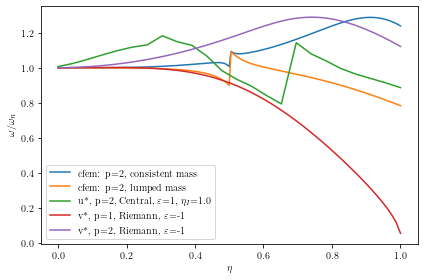

In [5]:
solutions = ([cfem_constn_p2,
              cfem_lumped_p2,
              us_cnt_p1_e1_p2,
              vs_rmn_m1_e1_p2,
              vs_rmn_m1_e0_p2] )
plot_solutions(solutions)

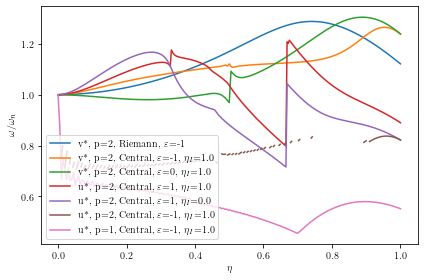

In [6]:
solutions = ([DG_1F_vStar_reimann_epsm1_eta0   ,
              DG_1F_vStar_central_epsm1_eta1   ,
              DG_1F_vStar_central_eps0_eta1    ,
              DG_1F_uStar_central_epsp1_eta1   ,
              DG_1F_uStar_central_epsp1_eta0   ,
              DG_1F_uStar_central_epsm1_eta1   ,
              DG_1F_uStar_central_epsm1_eta1_p1,] )

plot_solutions(solutions)

# CFEM

In [7]:
cfem_constn_p1 = read_keys('cfem/output_cfem_constn_p1')
cfem_lumped_p1 = read_keys('cfem/output_cfem_lumped_p1')

cfem_constn_p2 = read_keys('cfem/output_cfem_constn_p2')
cfem_lumped_p2 = read_keys('cfem/output_cfem_lumped_p2')

cfem_constn_p3 = read_keys('cfem/output_cfem_constn_p3')
cfem_lumped_p3 = read_keys('cfem/output_cfem_lumped_p3')

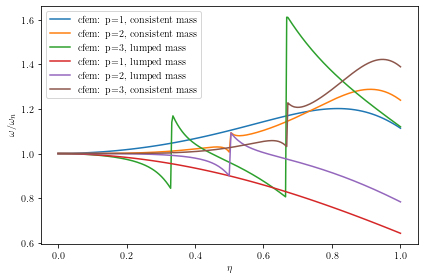

In [8]:
solutions = ([cfem_constn_p1,
              cfem_constn_p2,
              cfem_lumped_p3,
              cfem_lumped_p1,
              cfem_lumped_p2,
              cfem_constn_p3])

plot_solutions(solutions)

# U* p=1  $\varepsilon = +1,0,-1, \eta = 0,1,2,4,8$ 

In [9]:
us_cnt_p1_e0_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta0_p1')
us_cnt_p1_e1_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta1_p1')
us_cnt_p1_e2_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta2_p1')
us_cnt_p1_e3_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta3_p1')
us_cnt_p1_e4_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta4_p1')
us_cnt_p1_e8_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta8_p1')

us_cnt_0_e0_p1  = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta0_p1')
us_cnt_0_e1_p1  = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta1_p1')
us_cnt_0_e2_p1  = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta2_p1')
us_cnt_0_e3_p1  = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta3_p1')
us_cnt_0_e4_p1  = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta4_p1')
us_cnt_0_e8_p1  = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta8_p1')

us_cnt_m1_e0_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta0_p1')
us_cnt_m1_e1_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta1_p1')
us_cnt_m1_e2_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta2_p1')
us_cnt_m1_e3_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta3_p1')
us_cnt_m1_e4_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta4_p1')
us_cnt_m1_e8_p1 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta8_p1')

/tmp/ipykernel_1039/3272859738.py:141: RuntimeWarning: invalid value encountered in sqrt
  omega[i] = np.sqrt(eig_r[i])
/tmp/ipykernel_1039/3272859738.py:142: RuntimeWarning: invalid value encountered in sqrt
  omega_pi[i] = np.sqrt(eig_r[i])/(i+1)/np.pi


### $\varepsilon = +1$

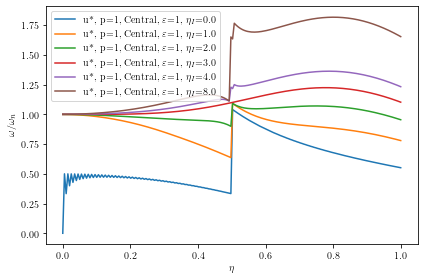

In [10]:
solutions = ([us_cnt_p1_e0_p1,
              us_cnt_p1_e1_p1,
              us_cnt_p1_e2_p1,
              us_cnt_p1_e3_p1,
              us_cnt_p1_e4_p1,
              us_cnt_p1_e8_p1] )
plot_solutions(solutions)

### $\varepsilon = 0$

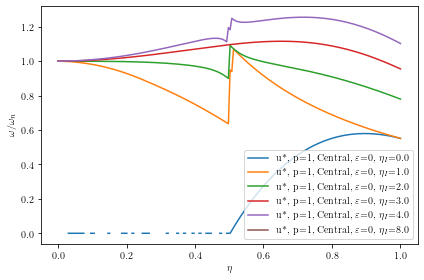

In [11]:
solutions = ([us_cnt_0_e0_p1,
              us_cnt_0_e1_p1,
              us_cnt_0_e2_p1,
              us_cnt_0_e3_p1,
              us_cnt_0_e4_p1,
              us_cnt_0_e8_p1] )
plot_solutions(solutions)

### $\varepsilon = -1$

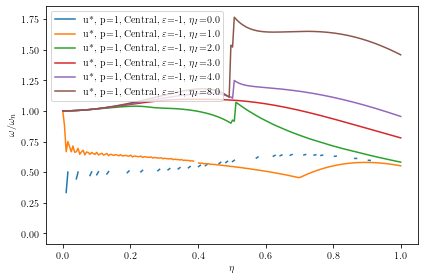

In [12]:
solutions = ([us_cnt_m1_e0_p1,
              us_cnt_m1_e1_p1,
              us_cnt_m1_e2_p1,
              us_cnt_m1_e3_p1,
              us_cnt_m1_e4_p1,
              us_cnt_m1_e8_p1] )
plot_solutions(solutions)

# U* p=2  $\varepsilon = +1,0,-1, \eta = 0,1,2,4,8$ 

In [13]:
us_cnt_p1_e0_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta0_p2')
us_cnt_p1_e1_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta1_p2')
us_cnt_p1_e2_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta2_p2')
us_cnt_p1_e3_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta3_p2')
us_cnt_p1_e4_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta4_p2')
us_cnt_p1_e8_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsp1_eta8_p2')

us_cnt_0_e0_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta0_p2')
us_cnt_0_e1_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta1_p2')
us_cnt_0_e2_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta2_p2')
us_cnt_0_e3_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta3_p2')
us_cnt_0_e4_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta4_p2')
us_cnt_0_e8_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_eps0_eta8_p2')

us_cnt_m1_e0_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta0_p2')
us_cnt_m1_e1_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta1_p2')
us_cnt_m1_e2_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta2_p2')
us_cnt_m1_e3_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta3_p2')
us_cnt_m1_e4_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta4_p2')
us_cnt_m1_e5_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta5_p2')
us_cnt_m1_e6_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta6_p2')
us_cnt_m1_e7_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta7_p2')
us_cnt_m1_e8_p2 = read_keys('u_star_eta/output_DG_1F_uStar_central_epsm1_eta8_p2')

/tmp/ipykernel_1039/3272859738.py:141: RuntimeWarning: invalid value encountered in sqrt
  omega[i] = np.sqrt(eig_r[i])
/tmp/ipykernel_1039/3272859738.py:142: RuntimeWarning: invalid value encountered in sqrt
  omega_pi[i] = np.sqrt(eig_r[i])/(i+1)/np.pi


### $\varepsilon = +1$

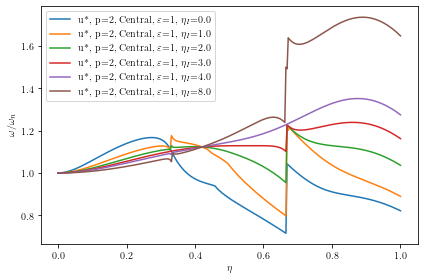

In [14]:
solutions = ([us_cnt_p1_e0_p2,
              us_cnt_p1_e1_p2,
              us_cnt_p1_e2_p2,
              us_cnt_p1_e3_p2,
              us_cnt_p1_e4_p2,
              us_cnt_p1_e8_p2] )
plot_solutions(solutions)

### $\varepsilon = 0$

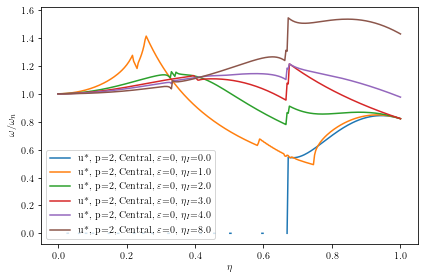

200


In [35]:
solutions = ([us_cnt_0_e0_p2,
              us_cnt_0_e1_p2,
              us_cnt_0_e2_p2,
              us_cnt_0_e3_p2,
              us_cnt_0_e4_p2,
              us_cnt_0_e8_p2] )
plot_solutions(solutions)

print(vs_cnt_0_e0_p1.count)

### $\varepsilon = -1$

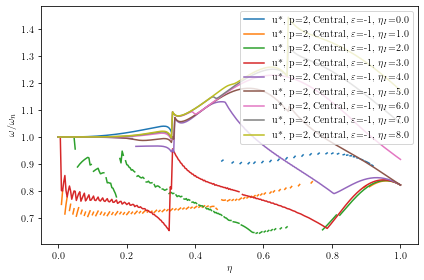

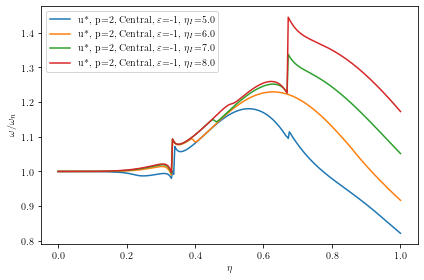

In [16]:
solutions = ([us_cnt_m1_e0_p2,
              us_cnt_m1_e1_p2,
              us_cnt_m1_e2_p2,
              us_cnt_m1_e3_p2,
              us_cnt_m1_e4_p2,
              us_cnt_m1_e5_p2,
              us_cnt_m1_e6_p2,
              us_cnt_m1_e7_p2,
              us_cnt_m1_e8_p2] )
plot_solutions(solutions)

solutions = ([us_cnt_m1_e5_p2,
              us_cnt_m1_e6_p2,
              us_cnt_m1_e7_p2,
              us_cnt_m1_e8_p2] )
plot_solutions(solutions)

# v* p=1 $\varepsilon = +1,0,-1, \eta = 0,1,2,4,8$ 

In [17]:
vs_cnt_p1_e0_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta0_p1')
vs_cnt_p1_e1_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta1_p1')
vs_cnt_p1_e2_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta2_p1')
vs_cnt_p1_e4_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta4_p1')
vs_cnt_p1_e8_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta8_p1')

vs_cnt_0_e0_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta0_p1')
vs_cnt_0_e1_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta1_p1')
vs_cnt_0_e2_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta2_p1')
vs_cnt_0_e4_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta4_p1')
vs_cnt_0_e8_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta8_p1')

vs_cnt_m1_e0_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta0_p1')
vs_cnt_m1_e1_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta1_p1')
vs_cnt_m1_e2_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta2_p1')
vs_cnt_m1_e4_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta4_p1')
vs_cnt_m1_e8_p1 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta8_p1')

### $\varepsilon = +1$

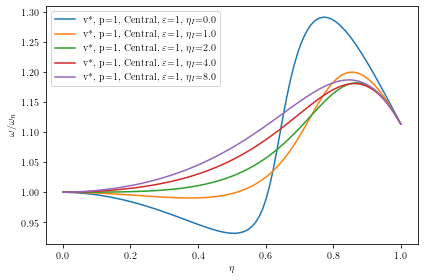

In [18]:
solutions = ([vs_cnt_p1_e0_p1,
              vs_cnt_p1_e1_p1,
              vs_cnt_p1_e2_p1,
              vs_cnt_p1_e4_p1,
              vs_cnt_p1_e8_p1] )
plot_solutions(solutions)

### $\varepsilon = 0$

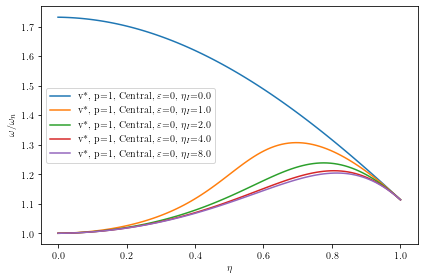

In [19]:
solutions = ([vs_cnt_0_e0_p1,
              vs_cnt_0_e1_p1,
              vs_cnt_0_e2_p1,
              vs_cnt_0_e4_p1,
              vs_cnt_0_e8_p1] )
plot_solutions(solutions)

### $\varepsilon = -1$

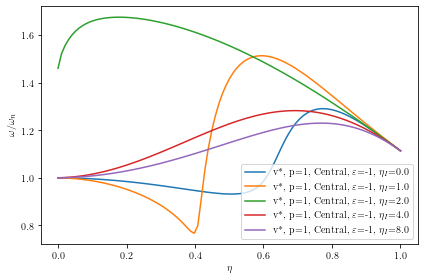

In [20]:
solutions = ([vs_cnt_m1_e0_p1,
              vs_cnt_m1_e1_p1,
              vs_cnt_m1_e2_p1,
              vs_cnt_m1_e4_p1,
              vs_cnt_m1_e8_p1] )
plot_solutions(solutions)

# v* p=2 $\varepsilon = +1,0,-1, \eta = 0,1,2,4,8$ 

In [21]:
vs_cnt_p1_e0_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta0_p2')
vs_cnt_p1_e1_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta1_p2')
vs_cnt_p1_e2_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta2_p2')
vs_cnt_p1_e4_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta4_p2')
vs_cnt_p1_e8_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsp1_eta8_p2')
vs_cnt_0_e0_p2   = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta0_p2')
vs_cnt_0_e1_p2   = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta1_p2')
vs_cnt_0_e2_p2   = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta2_p2')
vs_cnt_0_e4_p2   = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta4_p2')
vs_cnt_0_e8_p2   = read_keys('v_star_eta/output_DG_1F_vStar_central_eps0_eta8_p2')
vs_cnt_m1_e0_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta0_p2')
vs_cnt_m1_e1_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta1_p2')
vs_cnt_m1_e2_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta2_p2')
vs_cnt_m1_e4_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta4_p2')
vs_cnt_m1_e8_p2 = read_keys('v_star_eta/output_DG_1F_vStar_central_epsm1_eta8_p2')

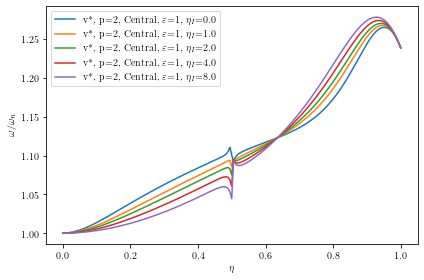

In [22]:
solutions = ([vs_cnt_p1_e0_p2,
              vs_cnt_p1_e1_p2,
              vs_cnt_p1_e2_p2,
              vs_cnt_p1_e4_p2,
              vs_cnt_p1_e8_p2] )
plot_solutions(solutions)

### $\varepsilon = 0$

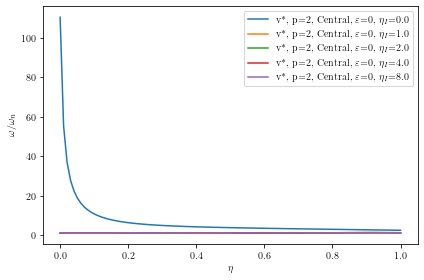

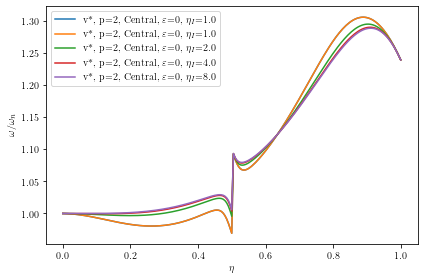

In [23]:
solutions = ([vs_cnt_0_e0_p2,
              vs_cnt_0_e1_p2,
              vs_cnt_0_e2_p2,
              vs_cnt_0_e4_p2,
              vs_cnt_0_e8_p2] )
plot_solutions(solutions)

solutions = ([ vs_cnt_0_e1_p2,
              vs_cnt_0_e1_p2,
              vs_cnt_0_e2_p2,
              vs_cnt_0_e4_p2,
              vs_cnt_0_e8_p2] )
plot_solutions(solutions)

### $\varepsilon = -1$

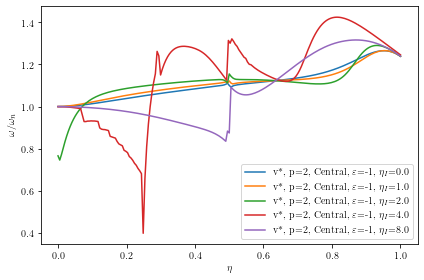

In [24]:
solutions = ([vs_cnt_m1_e0_p2,
              vs_cnt_m1_e1_p2,
              vs_cnt_m1_e2_p2,
              vs_cnt_m1_e4_p2,
              vs_cnt_m1_e8_p2] )
plot_solutions(solutions)

# 2F p=1

In [25]:
F2_cnt_p1_e0_p1 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta0_p1')
F2_cnt_p1_e1_p1 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta1_p1')
F2_cnt_p1_e2_p1 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta2_p1')
F2_cnt_p1_e4_p1 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta4_p1')
F2_cnt_p1_e8_p1 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta8_p1')

F2_cnt_0_e0_p1 = read_keys('2F_eta/output_DG_2F_central_eps0_eta0_p1')
F2_cnt_0_e1_p1 = read_keys('2F_eta/output_DG_2F_central_eps0_eta1_p1')
F2_cnt_0_e2_p1 = read_keys('2F_eta/output_DG_2F_central_eps0_eta2_p1')
F2_cnt_0_e4_p1 = read_keys('2F_eta/output_DG_2F_central_eps0_eta4_p1')
F2_cnt_0_e8_p1 = read_keys('2F_eta/output_DG_2F_central_eps0_eta8_p1')

F2_cnt_m1_e0_p1 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta0_p1')
F2_cnt_m1_e1_p1 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta1_p1')
F2_cnt_m1_e2_p1 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta2_p1')
F2_cnt_m1_e4_p1 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta4_p1')
F2_cnt_m1_e8_p1 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta8_p1')

### $\varepsilon = +1$

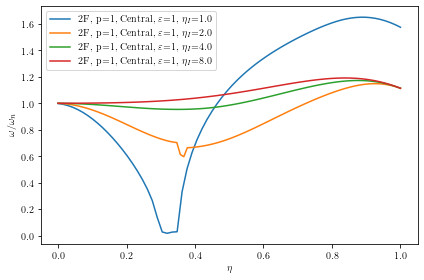

23
70
99
99
99


In [26]:
solutions = ([F2_cnt_p1_e1_p1,
              F2_cnt_p1_e2_p1,
              F2_cnt_p1_e4_p1,
              F2_cnt_p1_e8_p1] )
plot_solutions(solutions)

print(F2_cnt_p1_e0_p1.count)
print(F2_cnt_p1_e1_p1.count)
print(F2_cnt_p1_e2_p1.count)
print(F2_cnt_p1_e4_p1.count)
print(F2_cnt_p1_e8_p1.count)

### $\varepsilon = 0$

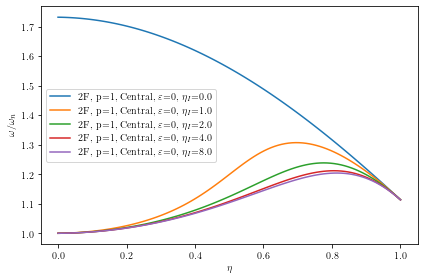

99
99
99
99
99


In [27]:
solutions = ([F2_cnt_0_e0_p1,
              F2_cnt_0_e1_p1,
              F2_cnt_0_e2_p1,
              F2_cnt_0_e4_p1,
              F2_cnt_0_e8_p1] )
plot_solutions(solutions)

print(F2_cnt_0_e0_p1.count)
print(F2_cnt_0_e1_p1.count)
print(F2_cnt_0_e2_p1.count)
print(F2_cnt_0_e4_p1.count)
print(F2_cnt_0_e8_p1.count)

### $\varepsilon = -1$

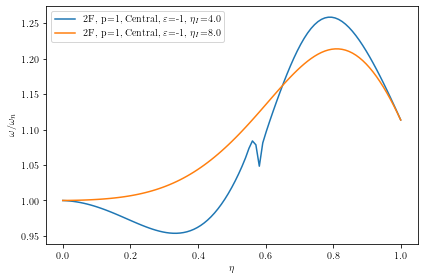

In [28]:
solutions = ([F2_cnt_m1_e4_p1,
              F2_cnt_m1_e8_p1] )
plot_solutions(solutions)

# 2F p=2  $\varepsilon = +1,0,-1, \eta = 0,1,2,4,8$ 

In [29]:
F2_cnt_p1_e0_p2 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta0_p2')
F2_cnt_p1_e1_p2 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta1_p2')
F2_cnt_p1_e2_p2 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta2_p2')
F2_cnt_p1_e4_p2 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta4_p2')
F2_cnt_p1_e8_p2 = read_keys('2F_eta/output_DG_2F_central_epsp1_eta8_p2')
F2_cnt_0_e0_p2  =  read_keys('2F_eta/output_DG_2F_central_eps0_eta0_p2')
F2_cnt_0_e1_p2  =  read_keys('2F_eta/output_DG_2F_central_eps0_eta1_p2')
F2_cnt_0_e2_p2  =  read_keys('2F_eta/output_DG_2F_central_eps0_eta2_p2')
F2_cnt_0_e4_p2  =  read_keys('2F_eta/output_DG_2F_central_eps0_eta4_p2')
F2_cnt_0_e8_p2  =  read_keys('2F_eta/output_DG_2F_central_eps0_eta8_p2')
F2_cnt_m1_e0_p2 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta0_p2')
F2_cnt_m1_e1_p2 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta1_p2')
F2_cnt_m1_e2_p2 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta2_p2')
F2_cnt_m1_e4_p2 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta4_p2')
F2_cnt_m1_e8_p2 = read_keys('2F_eta/output_DG_2F_central_epsm1_eta8_p2')

### $\varepsilon = +1$

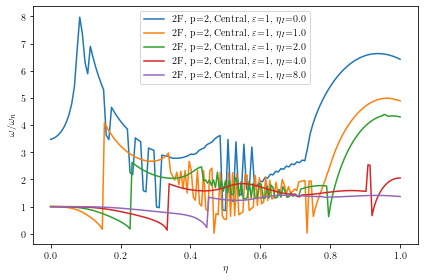

170
177
175
180


In [33]:
solutions = ([F2_cnt_p1_e0_p2,
    F2_cnt_p1_e1_p2,
              F2_cnt_p1_e2_p2,
              F2_cnt_p1_e4_p2,
              F2_cnt_p1_e8_p2] )
plot_solutions(solutions)

print(F2_cnt_p1_e1_p2.count)
print(F2_cnt_p1_e2_p2.count)
print(F2_cnt_p1_e4_p2.count)
print(F2_cnt_p1_e8_p2.count)

### $\varepsilon = 0$

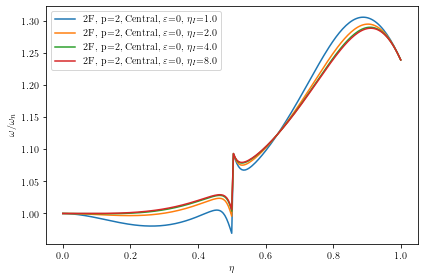

In [31]:
solutions = ([F2_cnt_0_e1_p2,
              F2_cnt_0_e2_p2,
              F2_cnt_0_e4_p2,
              F2_cnt_0_e8_p2] )
plot_solutions(solutions)

### $\varepsilon = -1$

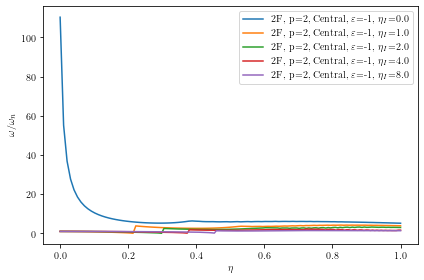

99
127
142
159
182


In [32]:
solutions = ([F2_cnt_m1_e0_p2,
                F2_cnt_m1_e1_p2,
              F2_cnt_m1_e2_p2,
              F2_cnt_m1_e4_p2,
              F2_cnt_m1_e8_p2] )
plot_solutions(solutions)

print(F2_cnt_m1_e0_p2.count)
print(F2_cnt_m1_e1_p2.count)
print(F2_cnt_m1_e2_p2.count)
print(F2_cnt_m1_e4_p2.count)
print(F2_cnt_m1_e8_p2.count)

# Riemann

In [41]:
F2_rmn_p1_e1_p1 = read_keys('riemann/output_DG_2F_riemann_epsp1_eta1_p1')
F2_rmn_p1_e1_p2 = read_keys('riemann/output_DG_2F_riemann_epsp1_eta1_p2')
F2_rmn_p1_e1_p3 = read_keys('riemann/output_DG_2F_riemann_epsp1_eta1_p3')

F2_rmn_0_e1_p1 = read_keys('riemann/output_DG_2F_riemann_eps0_eta1_p1')
F2_rmn_0_e1_p2 = read_keys('riemann/output_DG_2F_riemann_eps0_eta1_p2')
F2_rmn_0_e1_p3 = read_keys('riemann/output_DG_2F_riemann_eps0_eta1_p3')

F2_rmn_m1_e1_p1 = read_keys('riemann/output_DG_2F_riemann_epsm1_eta1_p1')
F2_rmn_m1_e1_p2 = read_keys('riemann/output_DG_2F_riemann_epsm1_eta1_p2')
F2_rmn_m1_e1_p3 = read_keys('riemann/output_DG_2F_riemann_epsm1_eta1_p3')

In [66]:
print(F2_rmn_p1_e1_p3.count)
print( F2_rmn_0_e1_p3.count)
print(F2_rmn_m1_e1_p3.count)


200
299
99


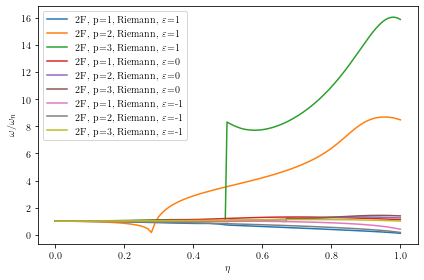

37
98
200
99
199
299
27
32
99


In [51]:
solutions = ([F2_rmn_p1_e1_p1,
              F2_rmn_p1_e1_p2,
              F2_rmn_p1_e1_p3,
              F2_rmn_0_e1_p1,
              F2_rmn_0_e1_p2,
              F2_rmn_0_e1_p3,
              F2_rmn_m1_e1_p1,
              F2_rmn_m1_e1_p2,
              F2_rmn_m1_e1_p3 ] )
plot_solutions(solutions)

print(F2_rmn_p1_e1_p1.count)
print(F2_rmn_p1_e1_p2.count)
print(F2_rmn_p1_e1_p3.count)
print(F2_rmn_0_e1_p1.count )
print(F2_rmn_0_e1_p2.count )
print(F2_rmn_0_e1_p3.count )
print(F2_rmn_m1_e1_p1.count)
print(F2_rmn_m1_e1_p2.count)
print(F2_rmn_m1_e1_p3.count)

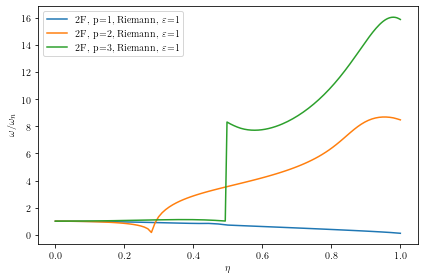

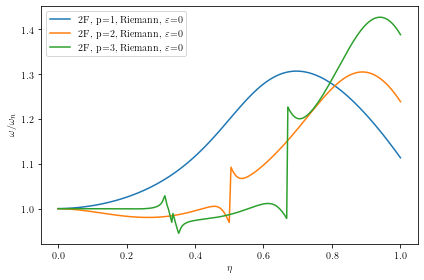

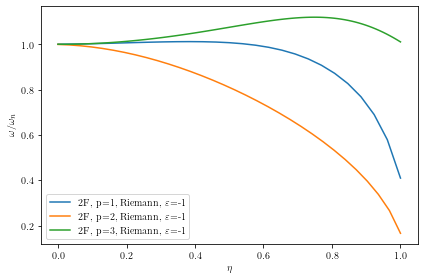

In [52]:
solutions = ([F2_rmn_p1_e1_p1,
              F2_rmn_p1_e1_p2,
              F2_rmn_p1_e1_p3,
                ] )
plot_solutions(solutions)
solutions = ([F2_rmn_0_e1_p1,
              F2_rmn_0_e1_p2,
              F2_rmn_0_e1_p3,] )
plot_solutions(solutions)
solutions = ([F2_rmn_m1_e1_p1,
              F2_rmn_m1_e1_p2,
              F2_rmn_m1_e1_p3 ] )
plot_solutions(solutions)

In [53]:
us_rmn_p1_e1_p1 = read_keys('riemann/output_DG_1F_uStar_riemann_epsp1_eta1_p1')
us_rmn_p1_e1_p2 = read_keys('riemann/output_DG_1F_uStar_riemann_epsp1_eta1_p1')
us_rmn_p1_e1_p3 = read_keys('riemann/output_DG_1F_uStar_riemann_epsp1_eta1_p1')
us_rmn_0_e1_p1  = read_keys('riemann/output_DG_1F_uStar_riemann_eps0_eta1_p1')
us_rmn_0_e1_p2  = read_keys('riemann/output_DG_1F_uStar_riemann_eps0_eta1_p1')
us_rmn_0_e1_p3  = read_keys('riemann/output_DG_1F_uStar_riemann_eps0_eta1_p1')
us_rmn_m1_e1_p1 = read_keys('riemann/output_DG_1F_uStar_riemann_epsm1_eta1_p1')
us_rmn_m1_e1_p2 = read_keys('riemann/output_DG_1F_uStar_riemann_epsm1_eta1_p1')
us_rmn_m1_e1_p3 = read_keys('riemann/output_DG_1F_uStar_riemann_epsm1_eta1_p1')

/tmp/ipykernel_1039/3272859738.py:141: RuntimeWarning: invalid value encountered in sqrt
  omega[i] = np.sqrt(eig_r[i])
/tmp/ipykernel_1039/3272859738.py:142: RuntimeWarning: invalid value encountered in sqrt
  omega_pi[i] = np.sqrt(eig_r[i])/(i+1)/np.pi


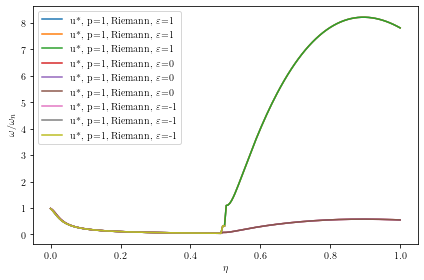

In [54]:
solutions = ([us_rmn_p1_e1_p1,
              us_rmn_p1_e1_p2,
              us_rmn_p1_e1_p3,
              us_rmn_0_e1_p1,
              us_rmn_0_e1_p2,
              us_rmn_0_e1_p3,
              us_rmn_m1_e1_p1,
              us_rmn_m1_e1_p2,
              us_rmn_m1_e1_p3] )
plot_solutions(solutions)

In [55]:
vs_rmn_p1_e1_p1 = read_keys('riemann/output_DG_1F_vStar_riemann_epsp1_eta1_p1')
vs_rmn_p1_e1_p2 = read_keys('riemann/output_DG_1F_vStar_riemann_epsp1_eta1_p2')
vs_rmn_p1_e1_p3 = read_keys('riemann/output_DG_1F_vStar_riemann_epsp1_eta1_p3')
vs_rmn_0_e1_p1  =  read_keys('riemann/output_DG_1F_vStar_riemann_eps0_eta1_p1')
vs_rmn_0_e1_p2  =  read_keys('riemann/output_DG_1F_vStar_riemann_eps0_eta1_p2')
vs_rmn_0_e1_p3  =  read_keys('riemann/output_DG_1F_vStar_riemann_eps0_eta1_p3')
vs_rmn_m1_e1_p1 = read_keys('riemann/output_DG_1F_vStar_riemann_epsm1_eta1_p1')
vs_rmn_m1_e1_p2 = read_keys('riemann/output_DG_1F_vStar_riemann_epsm1_eta1_p2')
vs_rmn_m1_e1_p3 = read_keys('riemann/output_DG_1F_vStar_riemann_epsm1_eta1_p3')

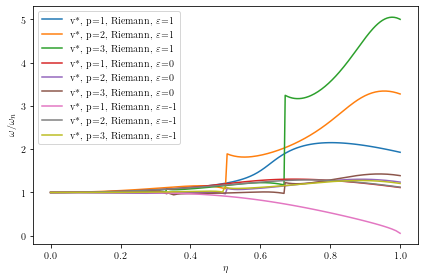

In [56]:
solutions = ([vs_rmn_p1_e1_p1,
              vs_rmn_p1_e1_p2,
              vs_rmn_p1_e1_p3,
              vs_rmn_0_e1_p1,
              vs_rmn_0_e1_p2,
              vs_rmn_0_e1_p3,
              vs_rmn_m1_e1_p1,
              vs_rmn_m1_e1_p2,
              vs_rmn_m1_e1_p3] )
plot_solutions(solutions)

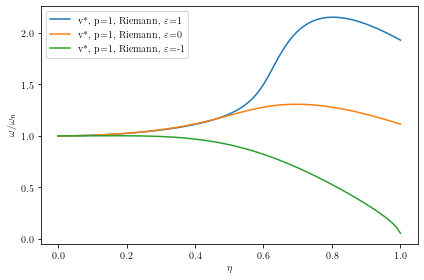

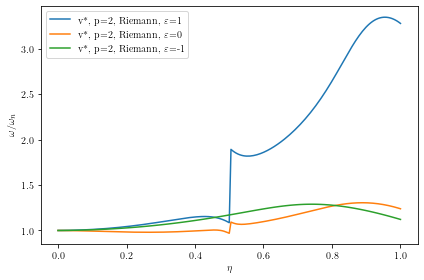

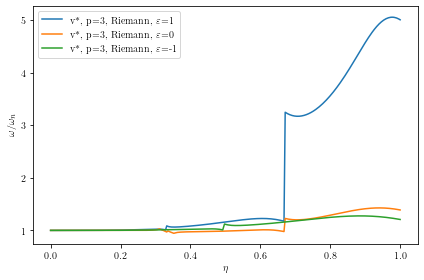

In [57]:
solutions = ([vs_rmn_p1_e1_p1,
               vs_rmn_0_e1_p1,
              vs_rmn_m1_e1_p1,] )
plot_solutions(solutions)

solutions = ([vs_rmn_p1_e1_p2,
               vs_rmn_0_e1_p2,
              vs_rmn_m1_e1_p2,] )
plot_solutions(solutions)

solutions = ([vs_rmn_p1_e1_p3,
               vs_rmn_0_e1_p3,
              vs_rmn_m1_e1_p3,] )
plot_solutions(solutions)

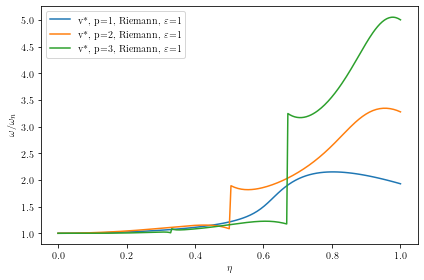

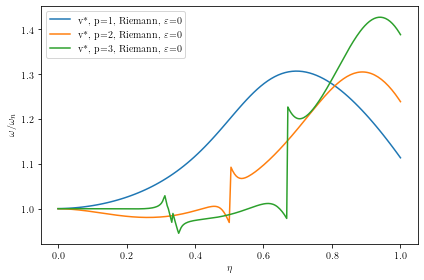

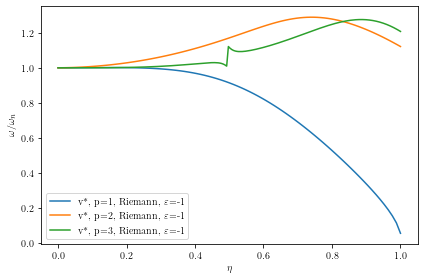

In [58]:
solutions = ([vs_rmn_p1_e1_p1,
              vs_rmn_p1_e1_p2,
              vs_rmn_p1_e1_p3,] )
plot_solutions(solutions)

solutions = ([vs_rmn_0_e1_p1,
              vs_rmn_0_e1_p2,
              vs_rmn_0_e1_p3,] )
plot_solutions(solutions)

solutions = ([vs_rmn_m1_e1_p1,
              vs_rmn_m1_e1_p2,
              vs_rmn_m1_e1_p3,] )
plot_solutions(solutions)

# v* comparison for $\varepsilon = +1,0,-1$ Riemann vs central

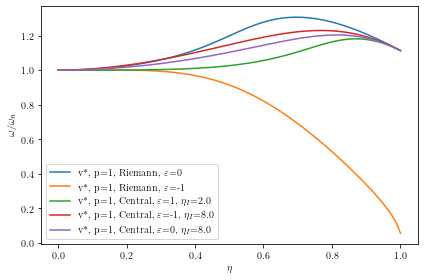

In [59]:
solutions = ([vs_rmn_0_e1_p1,
              vs_rmn_m1_e1_p1,
              vs_cnt_p1_e2_p1,
              vs_cnt_m1_e8_p1,
              vs_cnt_0_e8_p1,
              ] )
plot_solutions(solutions)

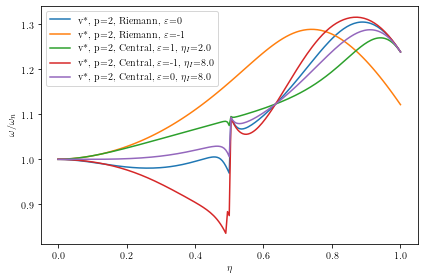

In [60]:
solutions = ([ vs_rmn_0_e1_p2,
              vs_rmn_m1_e1_p2,
              vs_cnt_p1_e2_p2,
              vs_cnt_m1_e8_p2,
               vs_cnt_0_e8_p2,] )
plot_solutions(solutions)

# u* comparison for $\varepsilon = +1,0,-1$; $0 \leq \eta \leq 8$

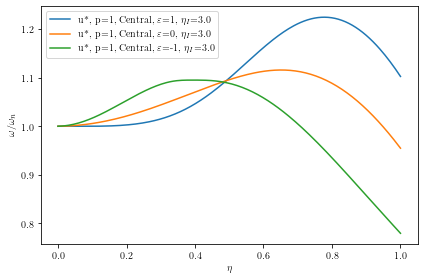

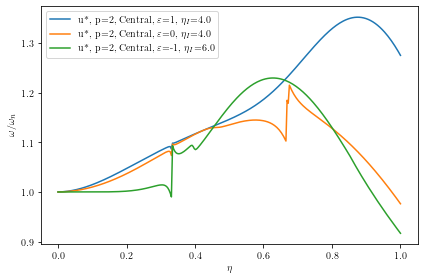

In [61]:
solutions = ([us_cnt_p1_e3_p1,
               us_cnt_0_e3_p1,
              us_cnt_m1_e3_p1,])
plot_solutions(solutions)

solutions = ([us_cnt_p1_e4_p2,
               us_cnt_0_e4_p2,
              us_cnt_m1_e6_p2,])
plot_solutions(solutions)

# Periodic

In [62]:
print(F2_rmn_0_e1_p1.count)

99


In [63]:
us_cnt_p1_e3_p1_periodic = read_keys('periodic/output_DG_1F_uStar_central_epsp1_eta3_p1_periodic')
cfem_lumped_p1_periodic = read_keys('periodic/output_cfem_lumped_p1_periodic') 
cfem_lumped_p2_periodic = read_keys('periodic/output_cfem_lumped_p2_periodic') 
vs_cnt_m1_e8_p2_periodic = read_keys('periodic/output_DG_1F_vStar_central_epsm1_eta8_p2_periodic')


PeriodicOrBloch
PeriodicOrBloch
PeriodicOrBloch


200
199


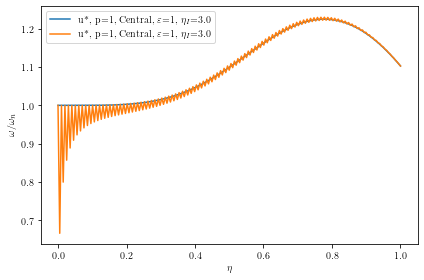

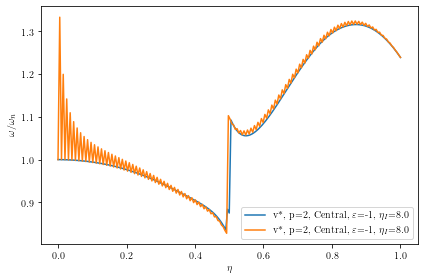

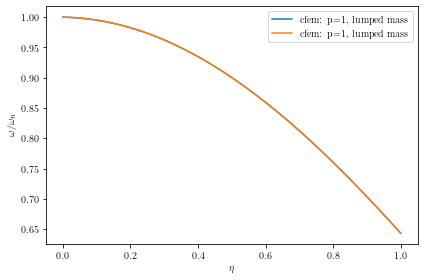

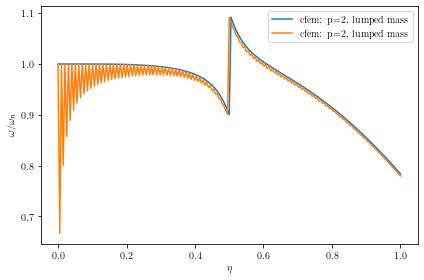

In [64]:
solutions = ([us_cnt_p1_e3_p1,
              us_cnt_p1_e3_p1_periodic,])

print(us_cnt_p1_e3_p1.count)
print(us_cnt_p1_e3_p1_periodic.count)
plot_solutions(solutions)

solutions = ([vs_cnt_m1_e8_p2,
              vs_cnt_m1_e8_p2_periodic,])

plot_solutions(solutions)


solutions = ([cfem_lumped_p1,
              cfem_lumped_p1_periodic,])

plot_solutions(solutions)

solutions = ([cfem_lumped_p2,
              cfem_lumped_p2_periodic,])

plot_solutions(solutions)
